# Parsing measurement data

In [1]:
import math

def lmap(f,x):
    return list(map(f,x))

def process_raw_decay_data(id, startTime = -1, threshold = 0.7, floating_avg = True):
    peaks = []

    # startTime == -1 => auto cutoff
    auto_cutoff = False
    if(startTime == -1):
        auto_cutoff = True
        startTime = 0

    with open(f"./inputs/{id}.csv") as inp:
        lines = inp.read().split("\n")

        startInd = 1
        while (float(lines[startInd].split(",")[0]) < startTime): startInd += 1
        
        hitPeak = False
        startPeak = 0
        endPeak = 0
        col_id = 2
        for i in range(startInd, len(lines)-1):
            row = lines[i].split(",")

            # convert to true time
            SR = 250

            if (float(row[col_id]) >= threshold and not hitPeak):
                hitPeak = True
                startPeak = float(row[0])/SR


            if (float(row[col_id]) < threshold and hitPeak):
                hitPeak = False
                endPeak = float(row[0])/SR

                peaks.append((endPeak+startPeak)/2)                

    

    results = {}
    interval = 1
    step = 0.1
    curTime = startTime
    x = 0
    while x < len(peaks):
        if (peaks[x] > curTime+interval):
            curTime += step
            x = 0
        elif (peaks[x] > curTime and peaks[x] < curTime+interval):
            if (not curTime in results): results[curTime] = 1
            else: results[curTime] += 1
            
        x += 1

    cutoff_val = math.inf
    if(auto_cutoff):
        cutoff_val = 0

    if(floating_avg):   
        with open(f"./outputs/{id}_PROCESSED_FLOATING_AVERAGE.csv", 'w') as res:
            res.write("t, peaks/s, omega \n")
            for x in range(4, len(results.keys())):
                flAverage = 0
                for y in range(5):
                    flAverage += results[list(results.keys())[x-y]]
                flAverage = flAverage/5

                if(auto_cutoff):
                    if(flAverage > cutoff_val):
                        cutoff_val = flAverage

                if(flAverage < cutoff_val):
                    res.write(str(round(list(results.keys())[x-y], 1)) + "," + str(flAverage) + "," + str(flAverage*2*2*math.pi/16) + "\n")

        return f"./outputs/{id}_PROCESSED_FLOATING_AVERAGE.csv"
    else:
        with open(f"./outputs/{id}_PROCESSED.csv", 'w') as res:
            res.write("t, peaks/s \n")
            for key in results.keys():
                res.write(str(round(key, 1)) + "," + str(results[key]) + "\n")
        
        return f"./outputs/{id}_PROCESSED.csv"


In [2]:
paths = [
    # "fan_slowing",
    "fan_slowing2"
]
processed_paths = []
for p in paths:
    out_path = process_raw_decay_data(p, 0, -300)
    processed_paths.append(out_path)

# Fitting for $\alpha$, $\gamma$, $c_1$

$$
\omega(t) = - \sqrt{\frac{\alpha}{\gamma}} \tan{(\sqrt{\alpha\gamma}(t+c_1))}
$$

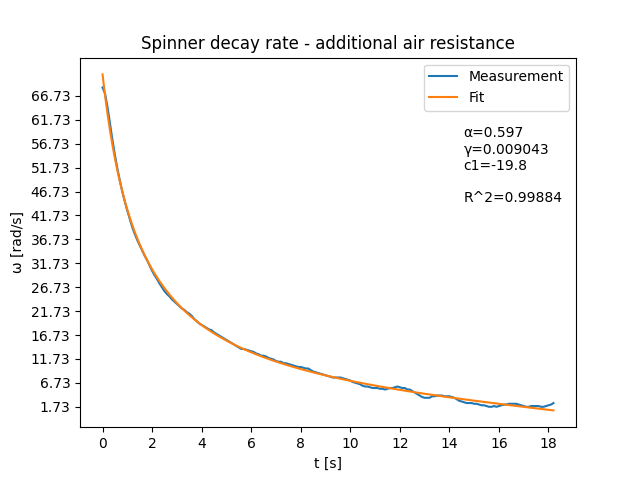

In [3]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib widget

alphas = []
gammas = []
cs = []
omega_0s = []
R_squares = []

def ω(time, alpha, gamma, c_1):
    return [
        - math.sqrt(alpha / gamma)
        * math.tan(math.sqrt(alpha * gamma) * (t + c_1))
        for t in time
    ]

for i in range(len(processed_paths)):
    path = processed_paths[i]
    with open(path, "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[2]), data)

        omega_0s.append(ydata[0])

        [alpha, gamma, c], pcov = opt.curve_fit(
            ω,
            xdata,
            ydata,
            bounds=(
                [0, 0, -math.inf],  # min
                [1, 0.01, 0],  # max
            ),
            p0=[0.21, 0.00025, -170],
            max_nfev=10000
        )
        perr = np.sqrt(np.diag(pcov))

        # calc R^2
        residuals = np.array(ydata) - np.array(ω(xdata, *[alpha, gamma, c]))
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((np.array(ydata) - np.mean(ydata))**2)
        r_squared = 1 - (ss_res / ss_tot)

        alphas.append(alpha)
        gammas.append(gamma)
        cs.append(c)
        R_squares.append(r_squared)

        plt.figure()

        plt.plot(xdata, ydata, label="Measurement")
        plt.xlabel("t [s]")
        plt.ylabel("ω [rad/s]")

        plt.yticks(np.arange(min(ydata), max(ydata) + 1, 5.0))
        plt.xticks(np.arange(min(xdata), max(xdata) + 1, 2.0))

        # plt.title(f"Spinner decay rate {i+1}")
        plt.title(f"Spinner decay rate - additional air resistance")
        plt.text(max(xdata) * 0.8, max(ydata) * 0.65, f"α={alpha:.3f}\nγ={gamma:.6f}\nc1={c:.1f}\n\nR^2={r_squared:.5f}")

        plt.plot([0, *xdata], ω([0, *xdata], alpha, gamma, c), label="Fit")
        plt.legend()


# Braking moment

$$
\tau = I\frac{d\omega}{dt} = I * -\alpha \sec^2(\sqrt{\alpha \gamma} (t + c_1))
$$

## Theoretical braking moment from drag

$$
F(r) = -\frac{1}{2} \rho C_D (S_{left} + S_{right}) v^2 = \\
\int_{0}^{R_{left}} -\frac{1}{2} \rho C_D h (r\omega)^2 dr + \int_{0}^{R_{right}} -\frac{1}{2} \rho C_D h (r\omega)^2 dr \\
$$
$$
\tau = F(\vec{r}, \omega) \times \vec{r} = -\frac{1}{8} ρ C_D h (R_{left}^4 + R_{right}^4) ω^2 \\
$$

$S_{left}, S_{right}$ ... area of the sides of the plate \
$R_{left}, R_{right}$ ... width of each of the sides of the plate \
$h$ ... height of the plate \
$C_d$ ... drag coefficient for the medium \
$\rho$ ... density of the medium


[-4.09201492e-07 -3.00288341e-21 -2.70287761e-05]


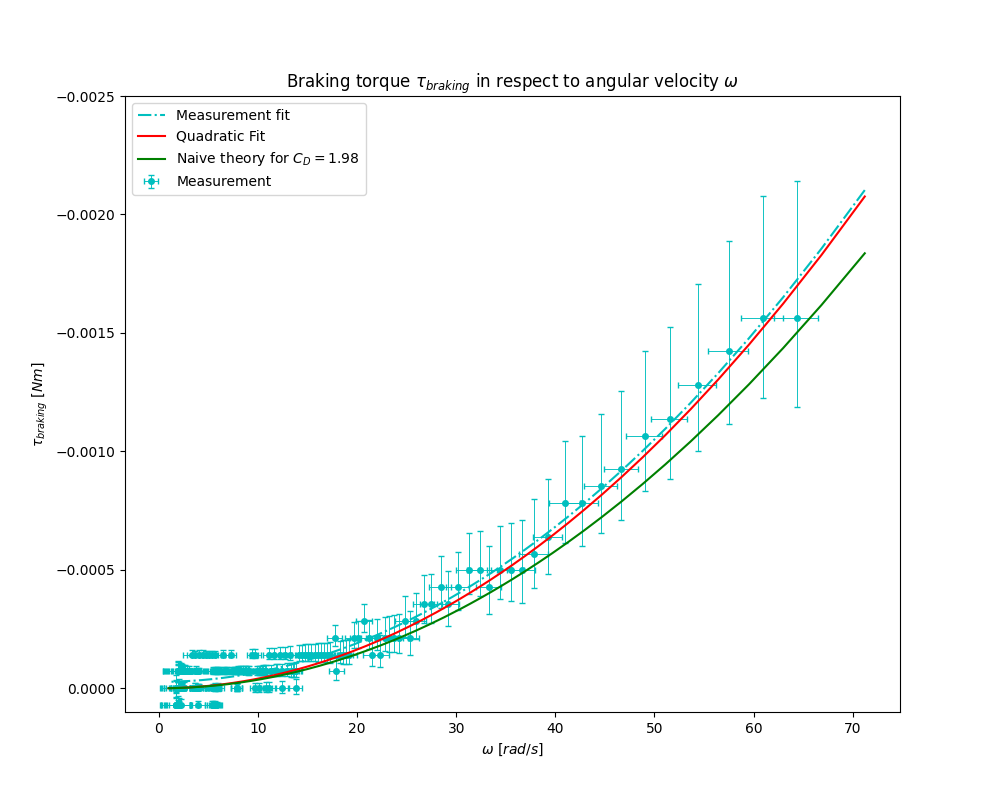

In [4]:
I = 4.52524e-5


def τ(time, alpha, gamma, c_1):
    return [
        I * -alpha * 1 / (math.cos(math.sqrt(alpha * gamma) * (t + c_1)) ** 2)
        for t in time
    ]


fit_coefs = np.zeros(3)

plt.figure(figsize=(10,8))
plt.title("Braking torque $\\tau_{braking}$ in respect to angular velocity $\\omega$")

cols = ["c", "r"]

for i in range(len(processed_paths)):
    path = processed_paths[i]
    with open(path, "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[2]), data)
        dt = 0.1

        plt.xlabel("$\\omega$ $[rad/s]$")
        plt.ylabel("$\\tau_{braking}$ $[Nm]$")

        plotx = ω([0, *xdata], alphas[i], gammas[i], cs[i])
        ploty = τ([0, *xdata], alphas[i], gammas[i], cs[i])

        coef = np.polyfit(plotx, ploty, 2)
        fit_coefs[0] += coef[0] / len(processed_paths)
        fit_coefs[1] += coef[1] / len(processed_paths)
        fit_coefs[2] += coef[2] / len(processed_paths)

        plt.plot(plotx, ploty, cols[i] + "-.", label=f"Measurement fit")

        measure_omeg = ydata[0:-1]
        measure_ang_acc = (np.diff(ydata) / np.diff(xdata) * I)

        (_, caps, _) = plt.errorbar(
            measure_omeg[2:],
            measure_ang_acc[2:],
            [
                lmap(
                    lambda id: abs(
                        τ(
                            [xdata[id] - 4 * (2 * math.pi / 16) / (dt * ydata[id])],
                            alphas[i],
                            gammas[i],
                            cs[i],
                        )[0]
                        - τ([xdata[id]], alphas[i], gammas[i], cs[i])[0]
                    ),
                    range(len([*xdata])),
                )[0:-1][2:],
                lmap(
                    lambda id: abs(
                        τ(
                            [xdata[id] + 4 * (2 * math.pi / 16) / (dt * ydata[id])],
                            alphas[i],
                            gammas[i],
                            cs[i],
                        )[0]
                        - τ([xdata[id]], alphas[i], gammas[i], cs[i])[0]
                    ),
                    range(len([*xdata])),
                )[0:-1][2:],
            ],
            [
                lmap(
                    lambda id: abs(
                        ω(
                            [xdata[id] - (2 * math.pi / 16) / (dt * ydata[id])],
                            alphas[i],
                            gammas[i],
                            cs[i],
                        )[0]
                        - ω([xdata[id]], alphas[i], gammas[i], cs[i])[0]
                    ),
                    range(len([*xdata])),
                )[0:-1][2:],
                lmap(
                    lambda id: abs(
                        ω(
                            [xdata[id] + (2 * math.pi / 16) / (dt * ydata[id])],
                            alphas[i],
                            gammas[i],
                            cs[i],
                        )[0]
                        - ω([xdata[id]], alphas[i], gammas[i], cs[i])[0]
                    ),
                    range(len([*xdata])),
                )[0:-1][2:],
            ],
            linestyle="None",
            color=cols[i],
            marker="o",
            markersize=4,
            capsize=2,
            elinewidth=0.65,
            # alpha=0.25,
            label="Measurement"
        )

        for cap in caps:
            cap.set_markeredgewidth(1)


# quadratic fit
def fit(xs):
    return [fit_coefs[0] * x * x for x in xs]
print(fit_coefs)

plt.plot(plotx, fit(plotx), "r-", label=f"Quadratic Fit", zorder=5)

# theoretically calcualted thingimajig
d = 0.111
shift = 0.005
R1 = (d) / 2 - shift
R2 = (d) / 2 + shift
h = 0.052
rho = 1.293
C_D = 1.98
# are we talking about a "long flat plate?" http://aerodyn.org/Drag/tables.html#bluff
# discrepancy can be explained by - wrong C_D, not accounting for other sources of turbulence (such as magnets or holes)

γ = 0.00068
I = 4.525e-5
def τ_theor(omegs):
    return [
        -1 / 8 * rho * C_D * h * (R1**4 + R2**4) * omeg**2
        -γ * omeg**2 * I
        for omeg in omegs
    ]


plt.plot(plotx, τ_theor(plotx), "g-", label=f"Naive theory for $C_D = {C_D}$", zorder=5)

plt.ylim(0.0001, -0.0025)
plt.legend(loc="upper left")